In [53]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import urllib.request

np.random.seed(seed=0)

In [54]:
data_path = "../data/"

df = pd.read_csv(data_path + "reviews.csv", nrows=10000)
print(df.head(3))
print(len(df))

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
10000


# Data Preprocessing

In [55]:
df = df[['Summary', 'Text']] # use only two columns
print(df.head(3))

                 Summary                                               Text
0  Good Quality Dog Food  I have bought several of the Vitality canned d...
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...
2  "Delight" says it all  This is a confection that has been around a fe...


In [56]:
# check null and duplicate
print(df.isnull().sum())
print(df.nunique())

df = df.dropna()
df = df.drop_duplicates(subset=['Text']) # drop duplicates in Text column
print(len(df))

Summary    0
Text       0
dtype: int64
Summary    8526
Text       9513
dtype: int64
9513


In [57]:
contractions = {"'cause": 'because',
                "I'd": 'I would',
                "I'd've": 'I would have',
                "I'll": 'I will',
                "I'll've": 'I will have',
                "I'm": 'I am',
                "I've": 'I have',
                "ain't": 'is not',
                "aren't": 'are not',
                "can't": 'cannot',
                "could've": 'could have',
                "couldn't": 'could not',
                "didn't": 'did not',
                "doesn't": 'does not',
                "don't": 'do not',
                "hadn't": 'had not',
                "hasn't": 'has not',
                "haven't": 'have not',
                "he'd": 'he would',
                "he'll": 'he will',
                "he's": 'he is',
                "here's": 'here is',
                "how'd": 'how did',
                "how'd'y": 'how do you',
                "how'll": 'how will',
                "how's": 'how is',
                "i'd": 'i would',
                "i'd've": 'i would have',
                "i'll": 'i will',
                "i'll've": 'i will have',
                "i'm": 'i am',
                "i've": 'i have',
                "isn't": 'is not',
                "it'd": 'it would',
                "it'd've": 'it would have',
                "it'll": 'it will',
                "it'll've": 'it will have',
                "it's": 'it is',
                "let's": 'let us',
                "ma'am": 'madam',
                "mayn't": 'may not',
                "might've": 'might have',
                "mightn't": 'might not',
                "mightn't've": 'might not have',
                "must've": 'must have',
                "mustn't": 'must not',
                "mustn't've": 'must not have',
                "needn't": 'need not',
                "needn't've": 'need not have',
                "o'clock": 'of the clock',
                "oughtn't": 'ought not',
                "oughtn't've": 'ought not have',
                "sha'n't": 'shall not',
                "shan't": 'shall not',
                "shan't've": 'shall not have',
                "she'd": 'she would',
                "she'd've": 'she would have',
                "she'll": 'she will',
                "she'll've": 'she will have',
                "she's": 'she is',
                "should've": 'should have',
                "shouldn't": 'should not',
                "shouldn't've": 'should not have',
                "so's": 'so as',
                "so've": 'so have',
                "that'd": 'that would',
                "that'd've": 'that would have',
                "that's": 'that is',
                "there'd": 'there would',
                "there'd've": 'there would have',
                "there's": 'there is',
                "they'd": 'they would',
                "they'd've": 'they would have',
                "they'll": 'they will',
                "they'll've": 'they will have',
                "they're": 'they are',
                "they've": 'they have',
                "this's": 'this is',
                "to've": 'to have',
                "wasn't": 'was not',
                "we'd": 'we would',
                "we'd've": 'we would have',
                "we'll": 'we will',
                "we'll've": 'we will have',
                "we're": 'we are',
                "we've": 'we have',
                "weren't": 'were not',
                "what'll": 'what will',
                "what'll've": 'what will have',
                "what're": 'what are',
                "what's": 'what is',
                "what've": 'what have',
                "when's": 'when is',
                "when've": 'when have',
                "where'd": 'where did',
                "where's": 'where is',
                "where've": 'where have',
                "who'll": 'who will',
                "who'll've": 'who will have',
                "who's": 'who is',
                "who've": 'who have',
                "why's": 'why is',
                "why've": 'why have',
                "will've": 'will have',
                "won't": 'will not',
                "won't've": 'will not have',
                "would've": 'would have',
                "wouldn't": 'would not',
                "wouldn't've": 'would not have',
                "y'all": 'you all',
                "y'all'd": 'you all would',
                "y'all'd've": 'you all would have',
                "y'all're": 'you all are',
                "y'all've": 'you all have',
                "you'd": 'you would',
                "you'd've": 'you would have',
                "you'll": 'you will',
                "you'll've": 'you will have',
                "you're": 'you are',
                "you've": 'you have'}

In [58]:
# stopwords
stopwords = set(stopwords.words('english'))
print(len(stopwords))

179


In [59]:
def preprocess_sentence(sentence, is_stopwords=True):
    sentence = sentence.lower()
    sentence = BeautifulSoup(sentence, features='lxml').text
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열  제거 e.g.,) my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence) 
    sentence = ' '.join([contractions[word] if word in contractions else word for word in sentence.split()])
    sentence = re.sub(r"'s\b","",sentence)
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    if is_stopwords:
        tokens = ' '.join([word for word in sentence.split() if not word in stopwords if len(word) > 1])
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    
    return tokens

# test
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, 0))

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [60]:
clean_text = []
for sentence in df['Text']:
    clean_sentence = preprocess_sentence(sentence)
    clean_text.append(clean_sentence)
    
df['Text'] = clean_text
    
clean_summary = []
for sentence in df['Summary']:
    clean_sentence = preprocess_sentence(sentence, 0)
    clean_summary.append(clean_sentence)
    
df['Summary'] = clean_summary
    
df.head(5)

<ipython-input-59-6c217c7be6b7>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, features='lxml').text


,Summary,Text
0,good quality dog food,bought several vitality canned dog food produc...
1,not as advertised,product arrived labeled jumbo salted peanuts p...
2,delight says it all,confection around centuries light pillowy citr...
3,cough medicine,looking secret ingredient robitussin believe f...
4,great taffy,great taffy great price wide assortment yummy ...


In [61]:
# check null and duplicate again
print(df.isnull().sum())
print(df.nunique())
print(len(df))

df = df.drop_duplicates(subset=['Text'])
print(len(df))

Summary    0
Text       0
dtype: int64
Summary    7643
Text       9508
dtype: int64
9513
9508


텍스트의 최소 길이 : 4
텍스트의 최대 길이 : 845
텍스트의 평균 길이 : 36.71424063946151
요약의 최소 길이 : 0
요약의 최대 길이 : 25
요약의 평균 길이 : 3.9328986116954145


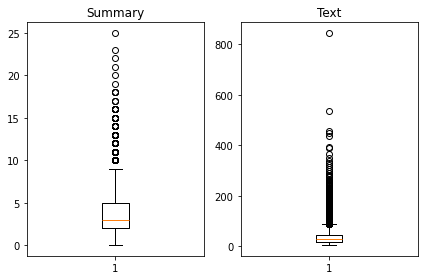

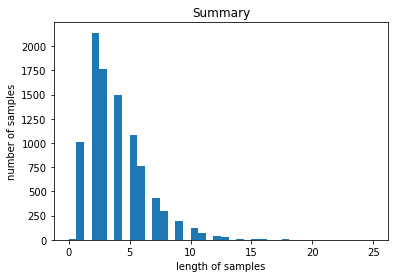

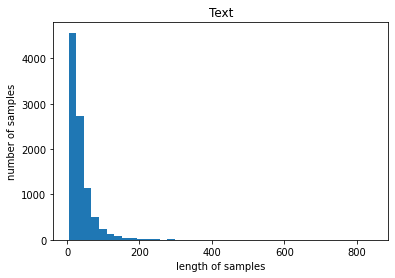

In [62]:
# 길이 분포 출력
text_len = [len(s.split()) for s in df['Text']]
summary_len = [len(s.split()) for s in df['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [63]:
text_max_len = 50
summary_max_len = 8

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))


below_threshold_len(text_max_len, df['Text'])
below_threshold_len(summary_max_len, df['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7974337400084139
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9467816575515355


In [64]:
df = df[df['Text'].apply(lambda row: len(row.split()) <= text_max_len)]
df = df[df['Summary'].apply(lambda row: len(row.split()) <= summary_max_len)]

print(len(df))
print(df.head(5))

7311
                 Summary                                               Text
0  good quality dog food  bought several vitality canned dog food produc...
1      not as advertised  product arrived labeled jumbo salted peanuts p...
2    delight says it all  confection around centuries light pillowy citr...
3         cough medicine  looking secret ingredient robitussin believe f...
4            great taffy  great taffy great price wide assortment yummy ...


### df[...]:
 - boolean indexing operation on the DataFrame df. The inner operation creates a boolean series, where each value is True if the condition is met (i.e., the text length is within the limit) and False otherwise.The df is then indexed with this boolean series, resulting in a new DataFrame that only contains rows where the condition is True.

# Tokenizing